## Developing the RF Model

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score

sns.set()
plt.rcParams["figure.figsize"] = (10, 8)
SEED = 42

train_ = pd.read_csv("assets/train.csv")
test_ = pd.read_csv("assets/test.csv")

train = train_.copy()
test = test_.copy()

In [2]:
num_features = set([c for c in train.columns if train[c].dtype != "object"])
cat_features = set([c for c in train.columns if c not in num_features])
print("Numerical Features: {}\nCategorical Features: {}".format(num_features, cat_features))

Numerical Features: {'Parch', 'SibSp', 'Age', 'Pclass', 'Fare', 'Survived', 'PassengerId'}
Categorical Features: {'Embarked', 'Sex', 'Name', 'Cabin', 'Ticket'}


#### Pre-Processing

**Dealing with Missing Values**

In [3]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

**Age**

Age is missing for 263 passengers. Let's replace the missing values with the mean age for now. This could be an area to come back to since age is one of the more important features in the dataset.

In [5]:
for df in [train, test]:
    df["Age"].fillna(df["Age"].mean(), inplace=True)

**Embarked**

Only 2 passengers are missing the Embarked feature. One option would be to replace with the mode:

In [6]:
train["Embarked"].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

Observe that both passengers missing Embarked data were in Pclass 1. Let's look at the Embarked value counts for Pclass 1:

In [7]:
train[train["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [8]:
train[train["Pclass"] == 1]["Embarked"].value_counts(normalize=True)

S    0.593458
C    0.397196
Q    0.009346
Name: Embarked, dtype: float64

Since the mode of Embarked for Pclass 1 is the same as the mode for the entire dataset, let's go ahead and replace the missing values with S.

In [9]:
for df in [train, test]:
    df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

**Fare**

Only one passenger is missing Fare. Let's replace with this missing value with the mean.

In [10]:
for df in [train, test]:
    df["Fare"].fillna(df["Fare"].mean(), inplace=True)

**Cabin**

1014 passengers are missing Cabin. We will deal with this later when we process categorical features.

## Feature Engineering

In [11]:
train.describe() # numerical features only

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
def engineer_numerical_features(df):
    temp = df.copy()
    
    genders = {"male": 0, "female": 1}
    temp["Sex"] = temp["Sex"].map(genders)
    
    temp["Age"].fillna(temp["Age"].mean(), inplace=True)
    
    temp["Fare"].fillna(temp["Fare"].mean(), inplace=True)
    
    family_size = temp["SibSp"] + temp["Parch"]
    temp["FamilySize"] = family_size
    
    age_class = temp["Age"] * temp["Pclass"]
    temp["AgeClass"] = age_class
    
    return temp


train = engineer_numerical_features(train)
test = engineer_numerical_features(test)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,AgeClass
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,1,66.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,38.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,78.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,1,35.0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,105.0


### Train Model - Numerical Only + Added Features

In [14]:
X = train.copy().drop(columns=cat_features)
y = X.pop("Survived")

rf = RandomForestClassifier(n_estimators=1000, random_state=SEED)
rf.fit(X, y)
scores = cross_val_score(rf, X, y, cv=5)

In [15]:
scores.mean()

0.692690228020769

In [16]:
yhat = cross_val_predict(rf, X, y, cv=5)
yhat[0:5]

array([0, 1, 0, 1, 0], dtype=int64)

In [17]:
roc_auc_score(y, yhat)

0.6633592177164221

### Categorical Variables

In [18]:
train["Name"].str.split(', ', expand=True).head()

,0,1
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina
3,Futrelle,Mrs. Jacques Heath (Lily May Peel)
4,Allen,Mr. William Henry


In [19]:
train_titles = train["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0].value_counts().to_frame().rename(columns={0: "Train"})
train_titles

,Train
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Col,2
Mlle,2
Major,2
Lady,1


In [20]:
test_titles = test["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0].value_counts().to_frame().rename(columns={0: "Test"})
test_titles

,Test
Mr,240
Miss,78
Mrs,72
Master,21
Rev,2
Col,2
Dr,1
Ms,1
Dona,1


Determine which titles are unique to train vs. test dataset:

In [21]:
title_counts = pd.concat([train_titles, test_titles], axis=1, sort=True).fillna(0)
title_counts["Total"] = title_counts.sum(axis=1)
title_counts.sort_values(by="Total", ascending=False, inplace=True)
title_counts[["Train", "Test", "Total"]] = title_counts[["Train", "Test", "Total"]].astype("int")
title_counts

,Train,Test,Total
Mr,517,240,757
Miss,182,78,260
Mrs,125,72,197
Master,40,21,61
Rev,6,2,8
Dr,7,1,8
Col,2,2,4
Ms,1,1,2
Major,2,0,2
Mlle,2,0,2


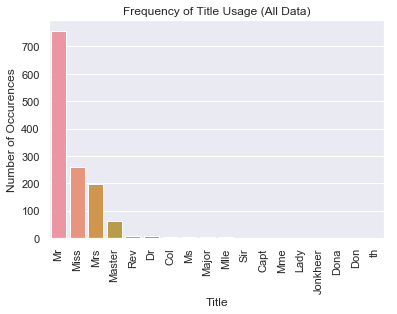

In [22]:
sns.barplot(data=title_counts.reset_index(), x="index", y="Total")
plt.xlabel("Title")
plt.xticks(rotation=90)
plt.ylabel("Number of Occurences")
plt.title("Frequency of Title Usage (All Data)")
plt.show()

In [23]:
title_counts.loc[(title_counts["Total"] <= 1), :]

,Train,Test,Total
Sir,1,0,1
Capt,1,0,1
Mme,1,0,1
Lady,1,0,1
Jonkheer,1,0,1
Dona,0,1,1
Don,1,0,1
th,1,0,1


In [24]:
test.loc[test["Name"].str.contains("Dona")]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,AgeClass
239,1131,1,"Douglas, Mrs. Walter Donald (Mahala Dutton)",1,48.0,1,0,PC 17761,106.425,C86,C,1,48.0
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.900,C105,C,0,39.0


In [97]:
def replace_rare_titles(df):
    title = df["Title"]
    if title in ["Capt", "Col", "Don", "Jonkheer", "Major", "Sir", "Rev"]:
        return "Mr"
    elif title in ["Mme", "th", "Lady", "Dona"]:
        return 'Mrs'
    elif title in ["Mlle", "Ms"]:
        return 'Miss'
    elif title =='Dr':
        if df['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [26]:
def substrings_in_string(big_string, substrings):
    if pd.isna(big_string):
        return "Unknown"
    for substring in substrings:
        if big_string.find(substring) != -1:
            if substring == "T":
                return "A"
            else:
                return substring

In [27]:
def list_decks():
    cabins = train["Cabin"].value_counts().index
    
    temp = []
    for c in cabins:
        for i in c:
            if i.isalpha():
                temp.append(i)

    return np.unique(temp)

In [28]:
cabin_list = np.append(list_decks(),"Unknown")
cabin_list

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Unknown'], dtype='<U7')

In [29]:
def engineer_categorical_features(df):
    temp = df.copy()
    
    temp["Embarked"].fillna(temp["Embarked"].mode()[0], inplace=True)
    
    titles = temp["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0]
    temp["Title"] = titles
    
    deck = temp["Cabin"].map(lambda x: substrings_in_string(x, cabin_list))
    temp["Deck"] = deck
    
    temp["Title"] = temp.apply(replace_rare_titles, axis=1)
    
    one_hot_cols = ["Embarked", "Title", "Deck"]
    
    for o in one_hot_cols:
        dummies = pd.get_dummies(temp[o], prefix=o)
        temp = pd.concat([temp, dummies], axis=1)
    
    temp.drop(columns=list(cat_features) + ["Title", "Deck"], inplace=True)
    
    return temp

train = engineer_categorical_features(train)
test = engineer_categorical_features(test)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,AgeClass,Embarked_C,...,Title_Mr,Title_Mrs,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_Unknown
0,1,0,3,22.0,1,0,7.2500,1,66.0,0,...,1,0,0,0,0,0,0,0,0,1
1,2,1,1,38.0,1,0,71.2833,1,38.0,1,...,0,1,0,0,1,0,0,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,78.0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,1,35.0,0,...,0,1,0,0,1,0,0,0,0,0
4,5,0,3,35.0,0,0,8.0500,0,105.0,0,...,1,0,0,0,0,0,0,0,0,1


In [30]:
train.isnull().sum().sum(), test.isnull().sum().sum() # confirm no missing values

(0, 0)

### Prepare Training Datasets

In [31]:
X = train.copy()
y = X.pop("Survived")

In [32]:
X.shape, test.shape

((891, 23), (418, 23))

In [33]:
X.columns, test.columns

(Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
        'AgeClass', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
        'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C',
        'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_Unknown'],
       dtype='object'),
 Index(['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
        'AgeClass', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
        'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Deck_A', 'Deck_B', 'Deck_C',
        'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_Unknown'],
       dtype='object'))

In [34]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [35]:
# rf = RandomForestClassifier(n_estimators=1000, random_state=SEED)
# rf.fit(X, y)

# scores = cross_val_score(rf, X, y, cv=5, scoring="accuracy")
# print(scores.mean())

In [36]:
def create_rf_model():
    return RandomForestClassifier(n_estimators=1000, random_state=SEED)

In [37]:
def train_score_model(X_train, X_val, y_train, y_val):
    rf = create_rf_model()
    rf.fit(X_train, y_train)
    yhat = rf.predict(X_val)
    
    roc = roc_auc_score(y_val, yhat) #receiver operating characteristic curve
    accuracy_train = rf.score(X_train, y_train) #r2 on training data
    accuracy_val = rf.score(X_val, y_val) #r2 on validation data
    
    return roc, accuracy_train, accuracy_val

### Train Model - All Features

In [38]:
rf = RandomForestClassifier(n_estimators=1000, random_state=SEED)
rf.fit(X, y)
scores = cross_val_score(rf, X, y, cv=5)

In [39]:
scores.mean()

0.8115479644384488

In [40]:
yhat = cross_val_predict(rf, X, y, cv=5)
yhat[0:5]

array([0, 1, 1, 1, 0], dtype=int64)

In [41]:
roc_auc_score(y, yhat)

0.7913191448566772

### Generate Submission

In [42]:
yhat = pd.DataFrame(rf.predict(test), columns=["Survived"])
yhat.head()

,Survived
0,0
1,0
2,0
3,1
4,1


In [43]:
submission_df = pd.DataFrame(columns=["PassengerId", "Survived"])
submission_df["PassengerId"] = test["PassengerId"]
submission_df["Survived"] = yhat["Survived"]
submission_df.to_csv("submissions/random_forest_feat_eng_2.csv", header=True, index=False)
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


## Testing

In [156]:
def engineer_numerical_features(df):
    temp = df.copy()
    
    # temp["Age"].fillna(temp["Age"].mean(), inplace=True)
    mean = temp["Age"].mean()
    std = temp["Age"].std()
    is_null = temp["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size=is_null)
    ages = temp["Age"].copy()
    ages[np.isnan(ages)] = rand_age
    temp["Age"] = ages
    temp["Age"] = temp["Age"].astype(int)

    temp.loc[temp["Age"] <= 18, "Age"] = 0
    temp.loc[(temp["Age"] > 18) & (temp["Age"] <= 23), "Age"] = 1
    temp.loc[(temp["Age"] > 23) & (temp["Age"] <= 28), "Age"] = 2
    temp.loc[(temp["Age"] > 28) & (temp["Age"] <= 34), "Age"] = 3
    temp.loc[(temp["Age"] > 34) & (temp["Age"] <= 44), "Age"] = 4
    temp.loc[(temp["Age"] > 44), "Age"] = 5

    #temp["Fare"].fillna(0, inplace=True)
    mean = temp["Fare"].mean()
    std = temp["Fare"].std()
    is_null = temp["Fare"].isnull().sum()
    rand_fare = np.random.randint(mean - std, mean + std, size=is_null)
    fares = temp["Fare"].copy()
    fares[np.isnan(fares)] = rand_fare
    temp["Fare"] = fares
    
    # Need to fix this binning:

    temp.loc[ temp["Fare"] <= 7.775, "Fare"] = 0
    temp.loc[(temp["Fare"] > 7.775) & (temp["Fare"] <= 8.662), "Fare"] = 1
    temp.loc[(temp["Fare"] > 8.662) & (temp["Fare"] <= 14.454), "Fare"] = 2
    temp.loc[(temp["Fare"] > 14.454) & (temp["Fare"] <= 26), "Fare"] = 3
    temp.loc[(temp["Fare"] > 26) & (temp["Fare"] <= 52.369), "Fare"] = 4
    temp.loc[ temp["Fare"] > 52.369, "Fare"] = 5
    temp["Fare"] = temp["Fare"].astype(int)
    
    family_size = temp["SibSp"] + temp["Parch"]
    temp["FamilySize"] = family_size
    
    fare_per_person = temp["Fare"] / (temp["FamilySize"] + 1)
    temp["FarePerPerson"] = fare_per_person
    
    age_class = temp["Age"] * temp["Pclass"]
    temp["AgeClass"] = age_class
    
    return temp

In [147]:
a = pd.qcut(train_["Fare"], q=6)
a.value_counts()

(-0.001, 7.775]      156
(7.775, 8.662]       152
(52.369, 512.329]    149
(14.454, 26.0]       149
(26.0, 52.369]       146
(8.662, 14.454]      139
Name: Fare, dtype: int64

In [148]:
a = pd.qcut(train_["Age"], q=6)
a.value_counts()

(0.419, 18.0]    139
(34.0, 44.0]     121
(28.0, 34.0]     116
(23.0, 28.0]     116
(44.0, 80.0]     115
(18.0, 23.0]     107
Name: Age, dtype: int64

In [149]:
def engineer_categorical_features(df):
    temp = df.copy()
    
    temp["Embarked"].fillna(temp["Embarked"].mode()[0], inplace=True)
    
    titles = temp["Name"].str.split(', ', expand=True)[1].str.split(". ", expand=True)[0]
    temp["Title"] = titles
    temp["Title"] = temp.apply(replace_rare_titles, axis=1)
    
    #deck = temp["Cabin"].map(lambda x: substrings_in_string(x, cabin_list))
    temp["Cabin"] = temp["Cabin"].fillna("U0")
    deck = temp["Cabin"].map(lambda x: x[0])
    temp["Deck"] = deck
    decks = {"A": 1, "T": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    temp["Deck"] = temp["Deck"].map(decks)
    temp["Deck"] = temp["Deck"].astype(int)
    
#     genders = {"male": 0, "female": 1}
#     temp["Sex"] = temp["Sex"].map(genders)
    
    ports = {"S": 0, "C": 1, "Q": 2}
    temp["Embarked"] = temp["Embarked"].map(ports)
    
    one_hot_cols = ["Title", "Sex"]
    
    for o in one_hot_cols:
        dummies = pd.get_dummies(temp[o], prefix=o)
        temp = pd.concat([temp, dummies], axis=1)
    
    temp.drop(columns=list(cat_features) + ["Title", "Sex", "PassengerId"], inplace=True)
    
    return temp

In [150]:
train_z = engineer_numerical_features(train_)
test_z = engineer_numerical_features(test_)

In [151]:
train_z = engineer_categorical_features(train_z)
test_z = engineer_categorical_features(test_z)

In [152]:
train_z["Fare"].value_counts(normalize=True)

3    0.175084
0    0.175084
5    0.167228
4    0.163861
2    0.162738
1    0.156004
Name: Fare, dtype: float64

In [153]:
train_z["Age"].value_counts().sort_index()

0    164
1    148
2    151
3    145
4    168
5    115
Name: Age, dtype: int64

In [154]:
train_z.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
       'FarePerPerson', 'AgeClass', 'Deck', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Sex_female', 'Sex_male'],
      dtype='object')

In [164]:
X = train_z.copy()
y = X.pop("Survived")
rf = RandomForestClassifier(n_estimators=1000, random_state=SEED)
rf.fit(X, y)
#scores = cross_val_score(rf, X, y, cv=5)
#scores.mean()
cv_results = cross_validate(rf, X, y, cv=5, return_train_score=True) # returns a dict of arrays containing the scores/times
print("Train Score: {}\nTest Score: {}\nFit Time: {}\nTest Stdev * 3: {}\n".format(
    cv_results["train_score"].mean(), 
    cv_results["test_score"].mean(), 
    cv_results["fit_time"].mean(), 
    cv_results["test_score"].std()*3))

Train Score: 0.917516510993196
Test Score: 0.8116109479191158
Fit Time: 0.6063829898834229
Test Stdev * 3: 0.13121883055084452



Train Score: 0.9135858976649267
Test Score: 0.8059739973267485
Fit Time: 0.2469468593597412
Test Stdev * 3: 0.11198147675167908

Train Score: 0.9149888161766748
Test Score: 0.8093699630504008
Fit Time: 0.2429518699645996
Test Stdev * 3: 0.12686837358381609

Train Score: 0.917516510993196
Test Score: 0.8082338134050551
Fit Time: 0.24993019104003905
Test Stdev * 3: 0.12041522118372955

In [165]:
rf.score(X, y)

0.9113355780022446

In [166]:
pred = cross_val_predict(rf, X, y, cv=5)
roc_auc_score(y, pred)

0.7929728693317993

In [167]:
yhat = rf.predict(test_z)
yhat[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [168]:
X.columns.values

array(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize',
       'FarePerPerson', 'AgeClass', 'Deck', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Sex_female', 'Sex_male'], dtype=object)

In [169]:
i = pd.DataFrame(rf.feature_importances_, index=X.columns.values, columns=["Importance"]).sort_values(by="Importance")
i

,Importance
Title_Master,0.015197
Parch,0.025052
Title_Miss,0.029468
Title_Mrs,0.029669
SibSp,0.041571
FamilySize,0.054547
Pclass,0.068190
Fare,0.069178
Age,0.070197
FarePerPerson,0.083819


In [170]:
# n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# random_grid = {"n_estimators": n_estimators}

# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, random_state=SEED)

# rf_random.fit(X, y)

In [171]:
#rf_random.best_params_

{'n_estimators': 400}

### Test Output

In [172]:
submission_df = pd.DataFrame(columns=["PassengerId", "Survived"])
submission_df["PassengerId"] = test_["PassengerId"]
submission_df["Survived"] = yhat
submission_df.to_csv("submissions/random_forest_feat_eng_6.csv", header=True, index=False)
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


**To Do**

- Drop passengerId feature
- Experiment with grouping titles - i.e. Rev should be Mr

**Resources**

* https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial